In [36]:
import os
os.environ["KERAS_BACKEND"] = "torch" # does not matter chose tensorflow or torch or jax 
import keras
print(keras.__version__)
print(keras.backend.backend())
from keras import layers
from scipy.io import loadmat

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit 
from sklearn.metrics import mean_squared_error # 
# set mat plot lib theme to white
plt.style.use('ggplot')

plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'savefig.facecolor': 'white',
    'axes.edgecolor': 'black',
    'axes.labelcolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'text.color': 'black'
})

3.9.2
torch


In [37]:
DEFAULT_BATCH_SIZE = 512 # as vram allows 
DEFAULT_VERBOSE_LEVEL = 2 # 0 for silent, 1 for progress bar, 2 for one line per epoch.

(1000,)


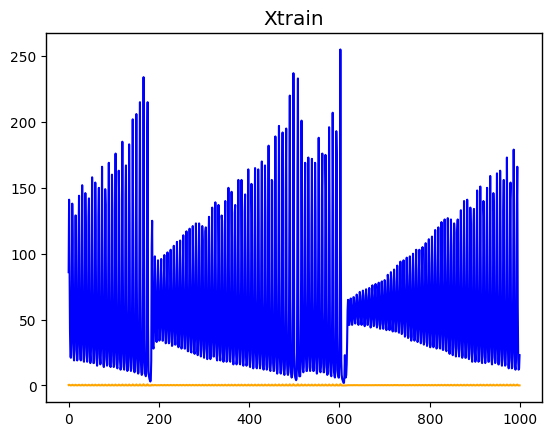

In [38]:
data = loadmat("Xtrain.mat")  
x_raw = data["Xtrain"].flatten()
print(x_raw.shape)
# Normalize
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(x_raw.reshape(-1, 1)).flatten()
#X_scaled = scaler.inverse_transform(X_scaled.reshape(-1, 1)).flatten()

# plot 
plt.plot(x_raw, label="raw", c ="blue")
plt.plot(X_scaled, label="scaled", c ="orange")
plt.title("Xtrain")
plt.show()

In [39]:

def create_dataset_2(data_sequence, lag):
    """Expects data_sequence to be a 2D numpy array where the time series is the first column.
    """
    X, y = [], []
    for i in range(lag, len(data_sequence)):
        X.append(data_sequence[i-lag:i, 0]) # Takes from the first column
        y.append(data_sequence[i, 0])      # Takes from the first column
    return np.array(X), np.array(y)


#  train_cv function - MODIFIED
def train_cv_modified(model, full_dataset: pd.DataFrame, lag_order=7, epochs=200,
                     patience_es=20, batch_size_param=DEFAULT_BATCH_SIZE, verbose_param=DEFAULT_VERBOSE_LEVEL):
    #fit the scaler.
    data_for_scaling = full_dataset.values
    if data_for_scaling.ndim == 1: # Ensure it's 2D for scaler
        data_for_scaling = data_for_scaling.reshape(-1, 1)

    scaled_data_values = scaler.fit_transform(data_for_scaling)

    model.scaled_data_full_history = scaled_data_values # Store the scaled version of the entire dataset

    # Create sequences using the scaled data
    X, y = create_dataset_2(scaled_data_values, lag_order)

    tscv = TimeSeriesSplit(n_splits=5)

    fold_count = 0
    fold_mses = []
    all_fold_predictions = []
    all_fold_actuals = []
    
    # Store histories if not using early stopping for averaging loss curves 
    training_losses_across_folds = []
    validation_losses_across_folds = []

    print(f"\nStarting Cross-Validation for model: {model.name}, Lag: {lag_order}")

    for train_index, test_index in tscv.split(X):
        fold_count += 1
        print(f"  Fold {fold_count}:")

        X_train_fold, X_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]

        # IMPORTANT: Reshape X_train_fold and X_test_fold for RNN/LSTM/GRU input
        num_features = 1
        X_train_fold_reshaped = X_train_fold.reshape((X_train_fold.shape[0], X_train_fold.shape[1], num_features))
        X_test_fold_reshaped = X_test_fold.reshape((X_test_fold.shape[0], X_test_fold.shape[1], num_features))

        
        execution_history = model.fit(X_train_fold_reshaped, y_train_fold,
                                      validation_data=(X_test_fold_reshaped, y_test_fold),
                                      epochs=epochs,
                                      batch_size=batch_size_param,                                      
                                      verbose=verbose_param)
        
        training_losses_across_folds.append(execution_history.history['loss'])
        validation_losses_across_folds.append(execution_history.history['val_loss'])


        # Perform predictions
        y_pred_scaled_fold = model.predict(X_test_fold_reshaped, verbose=verbose_param)

        # Descale predictions and actual values
        y_pred_descaled_fold = scaler.inverse_transform(y_pred_scaled_fold).flatten()
        all_fold_predictions.append(y_pred_descaled_fold)

        y_test_descaled_fold = scaler.inverse_transform(y_test_fold.reshape(-1, 1)).flatten()
        all_fold_actuals.append(y_test_descaled_fold)

        mse_fold = mean_squared_error(y_test_descaled_fold, y_pred_descaled_fold)
        fold_mses.append(mse_fold)
        print(f"    Fold {fold_count} - Test MSE: {mse_fold:.4f}")

    avg_mse = np.mean(fold_mses)
    std_mse = np.std(fold_mses)
    print(f"  Average MSE across all folds: {avg_mse:.4f} (+/- {std_mse:.4f})")

    # For history, if trying to average, ensure lists are not empty
    avg_train_loss_curve = None
    avg_val_loss_curve = None

    if training_losses_across_folds and validation_losses_across_folds   :
        # Pad shorter histories if epochs were fixed but something caused different lengths (should not happen if epochs fixed)
        min_epochs_ran = min(len(h) for h in training_losses_across_folds)
        trimmed_train_losses = [h[:min_epochs_ran] for h in training_losses_across_folds]
        trimmed_val_losses = [h[:min_epochs_ran] for h in validation_losses_across_folds]
        
        if trimmed_train_losses:
            avg_train_loss_curve = np.mean(np.array(trimmed_train_losses), axis=0)
        if trimmed_val_losses:
            avg_val_loss_curve = np.mean(np.array(trimmed_val_losses), axis=0)
            
  
    results = {
        "avg_mse": avg_mse,
        "std_mse": std_mse,
        "fold_mses": fold_mses,
        "all_fold_predictions": all_fold_predictions, # List of arrays
        "all_fold_actuals": all_fold_actuals,         # List of arrays
        "avg_train_loss_curve": avg_train_loss_curve, # Average loss curve (if meaningful)
        "avg_val_loss_curve": avg_val_loss_curve      # Average val_loss curve (if meaningful)
    }
    return results





In [40]:
data_mat = loadmat("Xtrain.mat")
x_raw_numpy = data_mat["Xtrain"].flatten() # This is a 1D NumPy array


full_dataset_df = pd.DataFrame(x_raw_numpy, columns=['value'])



In [ ]:
# model factories 
def build_rnn_model(input_len):
    model = keras.Sequential([
        layers.SimpleRNN(32, return_sequences=False, input_shape=(input_len, 1)),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_gru_model(input_len):
    model = keras.Sequential([
        layers.GRU(32, return_sequences=False, input_shape=(input_len, 1)),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_lstm_model(input_len):
    model = keras.Sequential([
        layers.LSTM(32, return_sequences=False, input_shape=(input_len, 1)),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


def build_big_gru_model(input_len):
    model = keras.Sequential([
        layers.GRU(128, return_sequences=True, input_shape=(input_len, 1), name="gru1"),
        layers.GRU(64, return_sequences=True, name="gru2"),
        layers.Dropout(0.2, name="dropout1"),
        layers.GRU(32, return_sequences=False, name="gru3"),
        layers.Dense(1, name="output_dense")
    ], name="BigGRU") 
    model.compile(optimizer='adam', loss='mse')
    return model


def build_big_gru_model2(input_len):
    model = keras.Sequential([
        layers.GRU(256, return_sequences=True, input_shape=(input_len, 1), name="gru1"),
        layers.Dropout(0.2, name="dropout1"),
        layers.GRU(128, return_sequences=True, name="gru2"),
        layers.Dropout(0.2, name="dropout2"),
        layers.GRU(64, return_sequences=True, name="gru3"),
        layers.Dense(1, name="output_dense")
    ], name="BigGRU") 
    model.compile(optimizer='adam', loss='mse')
    return model

def build_big_lstm_model(input_len):
    model = keras.Sequential([
        layers.LSTM(128, return_sequences=True, input_shape=(input_len, 1), name="lstm1"),
        # Removed redundant input_shape from second layer
        layers.LSTM(64, return_sequences=True, name="lstm2"),
        layers.Dropout(0.2, name="dropout1"),
        layers.LSTM(32, return_sequences=False, name="lstm3"),
        layers.Dense(1, name="output_dense")
    ], name="BigLSTM") 
    model.compile(optimizer='adam', loss='mse')
    return model



In [42]:
# --- KerasNLP-based Transformer Model Builder ---
def build_simple_transformer_model(    input_len,                  # Sequence length for the time series
    model_dim=64,               # The hidden dimensionality of the Transformer
    num_heads=4,                # Number of attention heads
    ff_intermediate_dim=128,    # Dimensionality of the FFN's inner layer in each Transformer block
    num_transformer_blocks=4,   # Number of Transformer blocks (fixed to 4 as requested)
    mlp_units=[64],             # Units for the final MLP head
    dropout_rate=0.1,           # Dropout rate used within Transformer blocks and MLP head
    name_prefix="SimpleTransformer"
):
    
   
    inputs = layers.Input(shape=(input_len, 1), name="input_timeseries")

    
    x = layers.Dense(model_dim, name="input_projection")(inputs)

    x = keras_nlp.layers.PositionEmbedding(
        sequence_length=input_len, name="positional_embedding"
    )(x)
    x = layers.Dropout(dropout_rate, name="embedding_dropout")(x)


    for i in range(num_transformer_blocks):
        x = keras_nlp.layers.TransformerEncoder(
            intermediate_dim=ff_intermediate_dim,
            num_heads=num_heads,
            dropout=dropout_rate, # This dropout is applied in MHA and FFN within the block
            name=f"transformer_encoder_block_{i+1}"
        )(x) # KerasNLP handles the internal MHA, FFN, LayerNorm, and residuals

    x = layers.Lambda(lambda seq: seq[:, -1, :], name="extract_last_timestep_output")(x)

    for units_val in mlp_units:
        x = layers.Dense(units_val, activation="relu")(x)
        if dropout_rate > 0: # Using the same dropout_rate for MLP head here
            x = layers.Dropout(dropout_rate)(x)
    
    outputs = layers.Dense(1, name="output_prediction")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name=f"{name_prefix}_{num_transformer_blocks}L")
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

--- Training BigGRU with input_len: 8 ---

Starting Cross-Validation for model: BigGRU, Lag: 8
  Fold 1:
Epoch 1/50


c:\Users\cemka\anaconda3\envs\dl\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 - 0s - 65ms/step - loss: 0.0816 - val_loss: 0.0237
Epoch 2/50
3/3 - 0s - 65ms/step - loss: 0.0569 - val_loss: 0.0284
Epoch 3/50
3/3 - 0s - 72ms/step - loss: 0.0552 - val_loss: 0.0213
Epoch 4/50
3/3 - 0s - 65ms/step - loss: 0.0508 - val_loss: 0.0229
Epoch 5/50
3/3 - 0s - 67ms/step - loss: 0.0510 - val_loss: 0.0209
Epoch 6/50
3/3 - 0s - 66ms/step - loss: 0.0477 - val_loss: 0.0192
Epoch 7/50
3/3 - 0s - 65ms/step - loss: 0.0453 - val_loss: 0.0193
Epoch 8/50
3/3 - 0s - 62ms/step - loss: 0.0419 - val_loss: 0.0171
Epoch 9/50
3/3 - 0s - 62ms/step - loss: 0.0385 - val_loss: 0.0159
Epoch 10/50
3/3 - 0s - 64ms/step - loss: 0.0350 - val_loss: 0.0139
Epoch 11/50
3/3 - 0s - 63ms/step - loss: 0.0296 - val_loss: 0.0140
Epoch 12/50
3/3 - 0s - 63ms/step - loss: 0.0249 - val_loss: 0.0098
Epoch 13/50
3/3 - 0s - 64ms/step - loss: 0.0179 - val_loss: 0.0089
Epoch 14/50
3/3 - 0s - 66ms/step - loss: 0.0148 - val_loss: 0.0120
Epoch 15/50
3/3 - 0s - 66ms/step - loss: 0.0131 - val_loss: 0.0103
Epoch 16/50
3/3

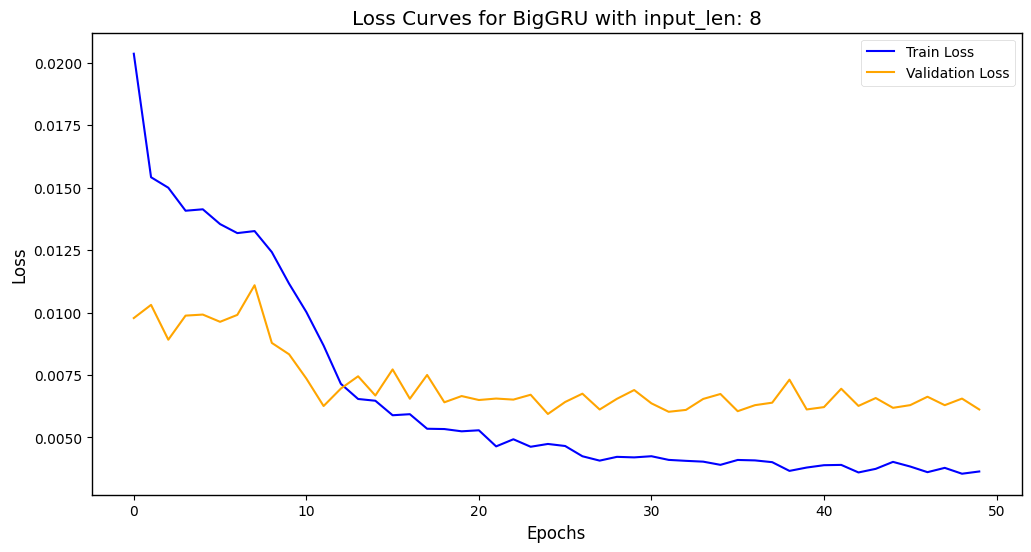

--- Training BigGRU with input_len: 10 ---

Starting Cross-Validation for model: BigGRU, Lag: 10
  Fold 1:
Epoch 1/50


c:\Users\cemka\anaconda3\envs\dl\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 - 0s - 84ms/step - loss: 0.0739 - val_loss: 0.0249
Epoch 2/50
3/3 - 0s - 79ms/step - loss: 0.0572 - val_loss: 0.0273
Epoch 3/50
3/3 - 0s - 78ms/step - loss: 0.0558 - val_loss: 0.0216
Epoch 4/50
3/3 - 0s - 78ms/step - loss: 0.0509 - val_loss: 0.0230
Epoch 5/50
3/3 - 0s - 75ms/step - loss: 0.0513 - val_loss: 0.0214
Epoch 6/50
3/3 - 0s - 75ms/step - loss: 0.0490 - val_loss: 0.0191
Epoch 7/50
3/3 - 0s - 73ms/step - loss: 0.0434 - val_loss: 0.0190
Epoch 8/50
3/3 - 0s - 72ms/step - loss: 0.0420 - val_loss: 0.0175
Epoch 9/50
3/3 - 0s - 74ms/step - loss: 0.0384 - val_loss: 0.0153
Epoch 10/50
3/3 - 0s - 81ms/step - loss: 0.0323 - val_loss: 0.0134
Epoch 11/50
3/3 - 0s - 78ms/step - loss: 0.0289 - val_loss: 0.0137
Epoch 12/50
3/3 - 0s - 73ms/step - loss: 0.0208 - val_loss: 0.0109
Epoch 13/50
3/3 - 0s - 77ms/step - loss: 0.0162 - val_loss: 0.0122
Epoch 14/50
3/3 - 0s - 80ms/step - loss: 0.0126 - val_loss: 0.0143
Epoch 15/50
3/3 - 0s - 82ms/step - loss: 0.0154 - val_loss: 0.0161
Epoch 16/50
3/3

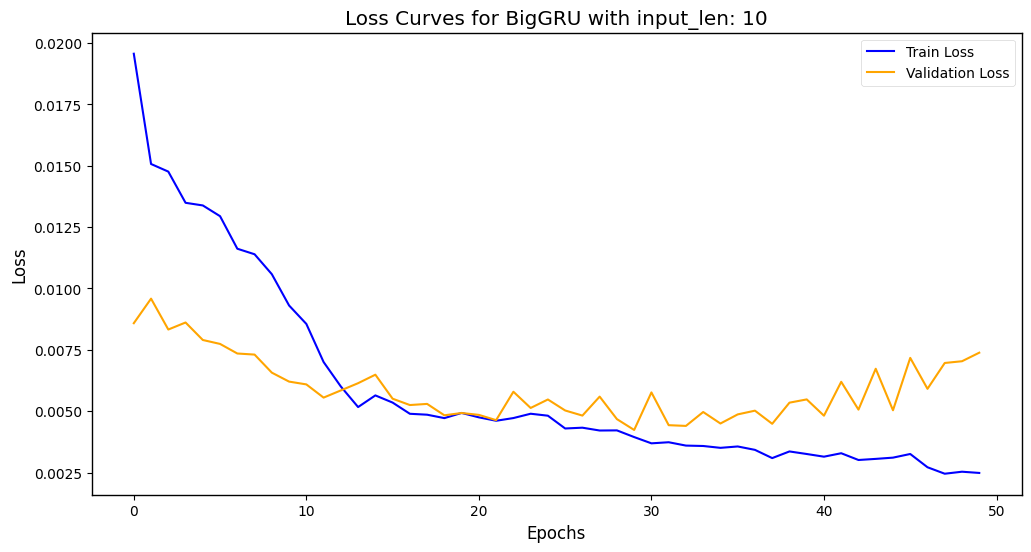

--- Training BigGRU with input_len: 20 ---

Starting Cross-Validation for model: BigGRU, Lag: 20
  Fold 1:
Epoch 1/50


c:\Users\cemka\anaconda3\envs\dl\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 - 0s - 135ms/step - loss: 0.0814 - val_loss: 0.0210
Epoch 2/50
3/3 - 0s - 128ms/step - loss: 0.0625 - val_loss: 0.0240
Epoch 3/50
3/3 - 0s - 132ms/step - loss: 0.0593 - val_loss: 0.0199
Epoch 4/50
3/3 - 0s - 133ms/step - loss: 0.0556 - val_loss: 0.0219
Epoch 5/50
3/3 - 0s - 129ms/step - loss: 0.0550 - val_loss: 0.0198
Epoch 6/50
3/3 - 0s - 135ms/step - loss: 0.0518 - val_loss: 0.0171
Epoch 7/50
3/3 - 0s - 131ms/step - loss: 0.0495 - val_loss: 0.0165
Epoch 8/50
3/3 - 0s - 131ms/step - loss: 0.0467 - val_loss: 0.0151
Epoch 9/50
3/3 - 0s - 130ms/step - loss: 0.0437 - val_loss: 0.0144
Epoch 10/50
3/3 - 0s - 129ms/step - loss: 0.0408 - val_loss: 0.0125
Epoch 11/50
3/3 - 0s - 136ms/step - loss: 0.0371 - val_loss: 0.0107
Epoch 12/50
3/3 - 0s - 140ms/step - loss: 0.0315 - val_loss: 0.0086
Epoch 13/50
3/3 - 0s - 134ms/step - loss: 0.0265 - val_loss: 0.0069
Epoch 14/50
3/3 - 0s - 135ms/step - loss: 0.0197 - val_loss: 0.0051
Epoch 15/50
3/3 - 0s - 134ms/step - loss: 0.0183 - val_loss: 0.0048


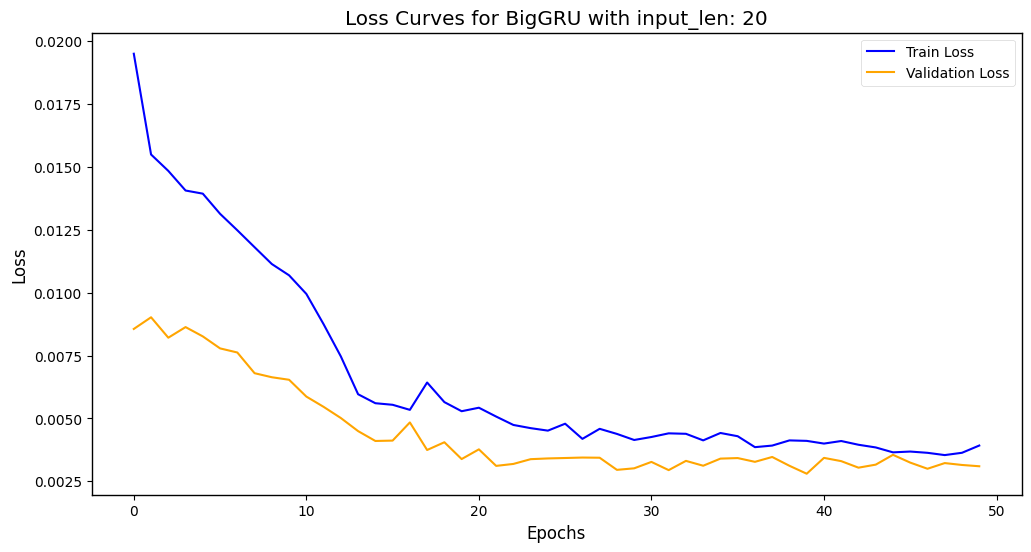

--- Training BigGRU with input_len: 30 ---

Starting Cross-Validation for model: BigGRU, Lag: 30
  Fold 1:
Epoch 1/50


c:\Users\cemka\anaconda3\envs\dl\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 - 1s - 196ms/step - loss: 0.0854 - val_loss: 0.0203
Epoch 2/50
3/3 - 1s - 195ms/step - loss: 0.0629 - val_loss: 0.0299
Epoch 3/50
3/3 - 1s - 195ms/step - loss: 0.0607 - val_loss: 0.0198
Epoch 4/50
3/3 - 1s - 195ms/step - loss: 0.0544 - val_loss: 0.0229
Epoch 5/50
3/3 - 1s - 190ms/step - loss: 0.0557 - val_loss: 0.0226
Epoch 6/50
3/3 - 1s - 188ms/step - loss: 0.0527 - val_loss: 0.0191
Epoch 7/50
3/3 - 1s - 187ms/step - loss: 0.0508 - val_loss: 0.0176
Epoch 8/50
3/3 - 1s - 210ms/step - loss: 0.0481 - val_loss: 0.0174
Epoch 9/50
3/3 - 1s - 205ms/step - loss: 0.0464 - val_loss: 0.0161
Epoch 10/50
3/3 - 1s - 195ms/step - loss: 0.0430 - val_loss: 0.0151
Epoch 11/50
3/3 - 1s - 194ms/step - loss: 0.0410 - val_loss: 0.0144
Epoch 12/50
3/3 - 1s - 190ms/step - loss: 0.0387 - val_loss: 0.0125
Epoch 13/50
3/3 - 1s - 189ms/step - loss: 0.0347 - val_loss: 0.0112
Epoch 14/50
3/3 - 1s - 191ms/step - loss: 0.0307 - val_loss: 0.0086
Epoch 15/50
3/3 - 1s - 195ms/step - loss: 0.0258 - val_loss: 0.0071


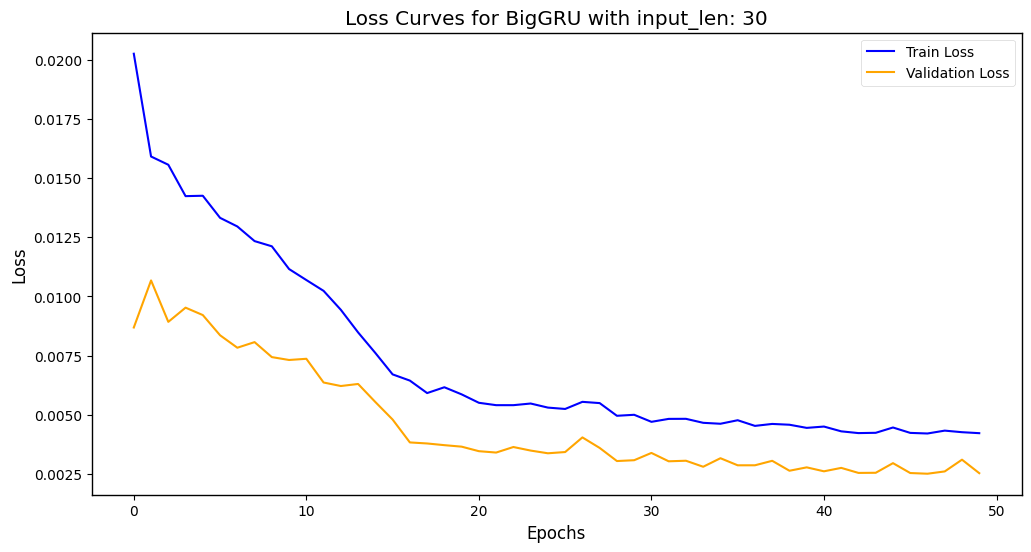

--- Training BigGRU with input_len: 40 ---

Starting Cross-Validation for model: BigGRU, Lag: 40
  Fold 1:
Epoch 1/50


c:\Users\cemka\anaconda3\envs\dl\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 - 1s - 301ms/step - loss: 0.0753 - val_loss: 0.0247
Epoch 2/50
3/3 - 1s - 248ms/step - loss: 0.0617 - val_loss: 0.0239
Epoch 3/50
3/3 - 1s - 244ms/step - loss: 0.0576 - val_loss: 0.0211
Epoch 4/50
3/3 - 1s - 246ms/step - loss: 0.0547 - val_loss: 0.0211
Epoch 5/50
3/3 - 1s - 245ms/step - loss: 0.0529 - val_loss: 0.0197
Epoch 6/50
3/3 - 1s - 247ms/step - loss: 0.0495 - val_loss: 0.0183
Epoch 7/50
3/3 - 1s - 247ms/step - loss: 0.0473 - val_loss: 0.0177
Epoch 8/50
3/3 - 1s - 241ms/step - loss: 0.0462 - val_loss: 0.0162
Epoch 9/50
3/3 - 1s - 245ms/step - loss: 0.0422 - val_loss: 0.0148
Epoch 10/50
3/3 - 1s - 259ms/step - loss: 0.0386 - val_loss: 0.0136
Epoch 11/50
3/3 - 1s - 250ms/step - loss: 0.0359 - val_loss: 0.0113
Epoch 12/50
3/3 - 1s - 247ms/step - loss: 0.0309 - val_loss: 0.0090
Epoch 13/50
3/3 - 1s - 248ms/step - loss: 0.0257 - val_loss: 0.0065
Epoch 14/50
3/3 - 1s - 243ms/step - loss: 0.0219 - val_loss: 0.0041
Epoch 15/50
3/3 - 1s - 243ms/step - loss: 0.0201 - val_loss: 0.0026


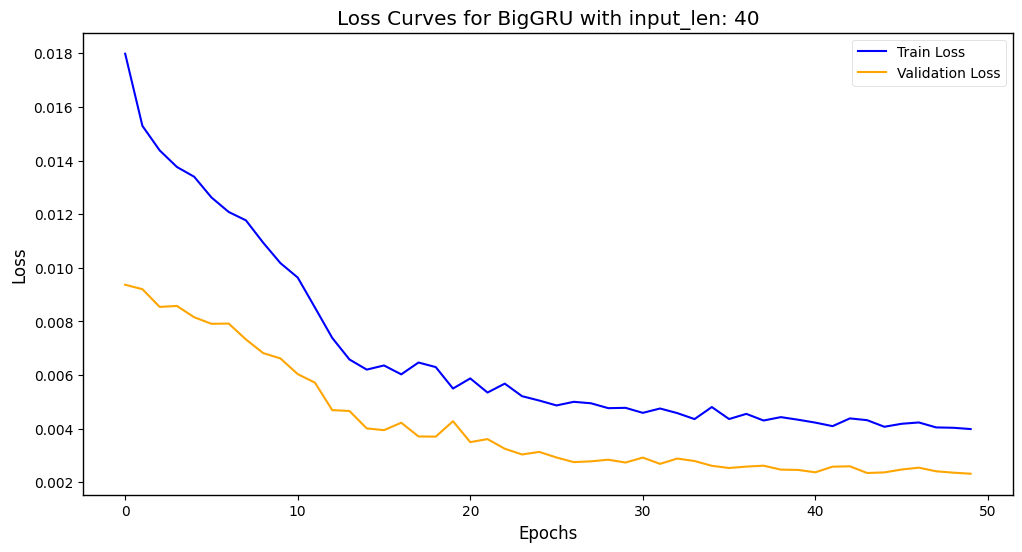

--- Training BigGRU with input_len: 50 ---

Starting Cross-Validation for model: BigGRU, Lag: 50
  Fold 1:
Epoch 1/50


c:\Users\cemka\anaconda3\envs\dl\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 - 1s - 296ms/step - loss: 0.0926 - val_loss: 0.0222
Epoch 2/50
3/3 - 1s - 292ms/step - loss: 0.0540 - val_loss: 0.0312
Epoch 3/50
3/3 - 1s - 313ms/step - loss: 0.0606 - val_loss: 0.0221
Epoch 4/50
3/3 - 1s - 298ms/step - loss: 0.0507 - val_loss: 0.0219
Epoch 5/50
3/3 - 1s - 297ms/step - loss: 0.0511 - val_loss: 0.0224
Epoch 6/50
3/3 - 1s - 291ms/step - loss: 0.0500 - val_loss: 0.0205
Epoch 7/50
3/3 - 1s - 293ms/step - loss: 0.0470 - val_loss: 0.0188
Epoch 8/50
3/3 - 1s - 298ms/step - loss: 0.0457 - val_loss: 0.0181
Epoch 9/50
3/3 - 1s - 299ms/step - loss: 0.0435 - val_loss: 0.0169
Epoch 10/50
3/3 - 1s - 297ms/step - loss: 0.0403 - val_loss: 0.0158
Epoch 11/50
3/3 - 1s - 296ms/step - loss: 0.0379 - val_loss: 0.0145
Epoch 12/50
3/3 - 1s - 294ms/step - loss: 0.0344 - val_loss: 0.0121
Epoch 13/50
3/3 - 1s - 299ms/step - loss: 0.0299 - val_loss: 0.0098
Epoch 14/50
3/3 - 1s - 293ms/step - loss: 0.0252 - val_loss: 0.0075
Epoch 15/50
3/3 - 1s - 299ms/step - loss: 0.0205 - val_loss: 0.0047


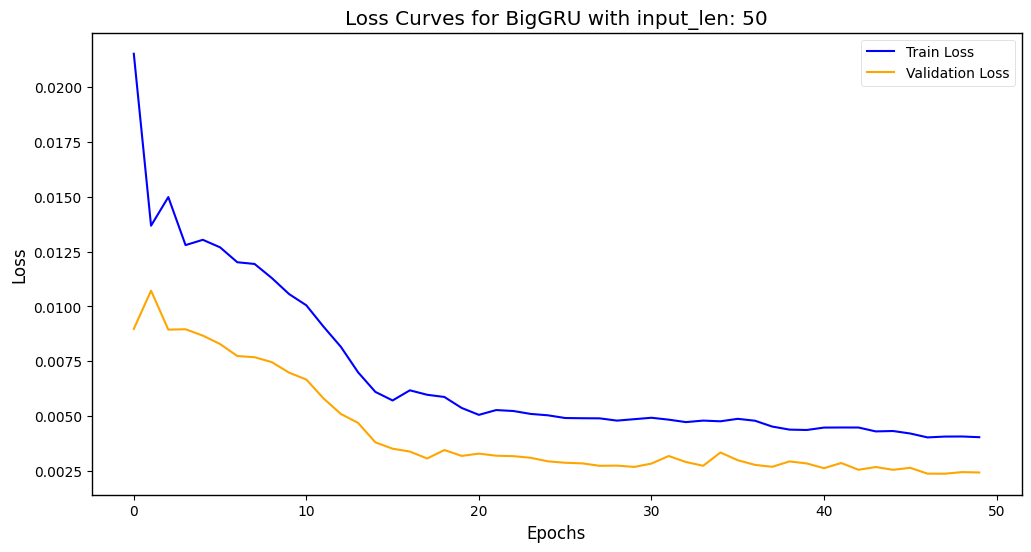

--- Training BigGRU with input_len: 100 ---

Starting Cross-Validation for model: BigGRU, Lag: 100
  Fold 1:


c:\Users\cemka\anaconda3\envs\dl\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
3/3 - 2s - 574ms/step - loss: 0.0747 - val_loss: 0.0319
Epoch 2/50
3/3 - 2s - 572ms/step - loss: 0.0490 - val_loss: 0.0392
Epoch 3/50
3/3 - 2s - 564ms/step - loss: 0.0544 - val_loss: 0.0313
Epoch 4/50
3/3 - 2s - 563ms/step - loss: 0.0457 - val_loss: 0.0315
Epoch 5/50
3/3 - 2s - 572ms/step - loss: 0.0457 - val_loss: 0.0323
Epoch 6/50
3/3 - 2s - 565ms/step - loss: 0.0445 - val_loss: 0.0300
Epoch 7/50
3/3 - 2s - 569ms/step - loss: 0.0427 - val_loss: 0.0276
Epoch 8/50
3/3 - 2s - 575ms/step - loss: 0.0412 - val_loss: 0.0269
Epoch 9/50
3/3 - 2s - 560ms/step - loss: 0.0397 - val_loss: 0.0260
Epoch 10/50
3/3 - 2s - 566ms/step - loss: 0.0385 - val_loss: 0.0246
Epoch 11/50
3/3 - 2s - 580ms/step - loss: 0.0364 - val_loss: 0.0237
Epoch 12/50
3/3 - 2s - 562ms/step - loss: 0.0355 - val_loss: 0.0225
Epoch 13/50
3/3 - 2s - 563ms/step - loss: 0.0324 - val_loss: 0.0198
Epoch 14/50
3/3 - 2s - 563ms/step - loss: 0.0296 - val_loss: 0.0174
Epoch 15/50
3/3 - 2s - 569ms/step - loss: 0.0268 - val_lo

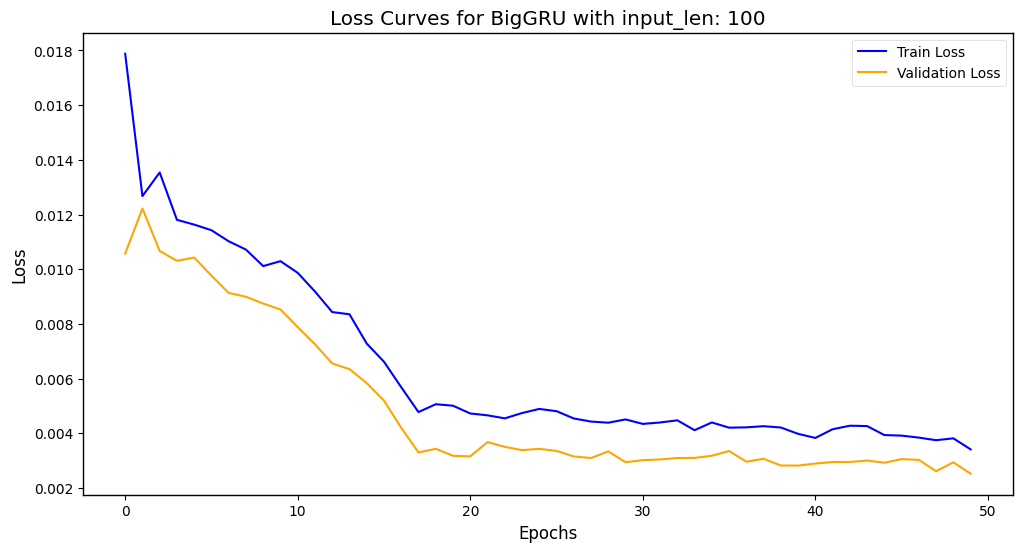

In [43]:
input_lens_to_test = [8, 10 , 20, 30, 40, 50, 100]  # 5 , 10 , 20, 30, 50, 100, 200,
model_builders = {
    "BigGRU": build_big_gru_model,

}
experiment_results = {name: [] for name in model_builders}

# Training parameters
num_epochs = 50 # 
# Use global defaults or specify:
batch_size_for_training = 64 #  smaller seem sto wrok better fro this amount of data 
verbose_level_for_training = 2 #  0 for silent, 1 for progress bar


for model_name, model_builder_func in model_builders.items():
    for current_input_len in input_lens_to_test:
        print(f"--- Training {model_name} with input_len: {current_input_len} ---")

        #  Build the model for the  config
        current_keras_model = model_builder_func(input_len=current_input_len)
        # current_keras_model.summary() 

        # Train   modified train_cv function
        cv_run_results = train_cv_modified(
            model=current_keras_model,
            full_dataset=full_dataset_df, # Pass the DataFrame
            lag_order=current_input_len,
            epochs=num_epochs,
            batch_size_param=batch_size_for_training,
            verbose_param=verbose_level_for_training
        )

        #  Store results
        result_entry = {
            'input_len': current_input_len,
            'avg_mse': cv_run_results['avg_mse'],
            'std_mse': cv_run_results['std_mse'],
            'fold_mses': cv_run_results['fold_mses']
        }
        experiment_results[model_name].append(result_entry)
        print(f"--- Finished {model_name} with input_len: {current_input_len}, Avg MSE: {cv_run_results['avg_mse']:.4f} ---")
        # save model to disk
        current_keras_model.save(f"cem_models/{model_name}_Mse_{cv_run_results['avg_mse']:.2f}_input_len_{current_input_len}.keras") 
        #plot the loss curves
        if cv_run_results['avg_train_loss_curve'] is not None and cv_run_results['avg_val_loss_curve'] is not None:
            plt.figure(figsize=(12, 6))
            plt.plot(cv_run_results['avg_train_loss_curve'], label='Train Loss', color='blue')
            plt.plot(cv_run_results['avg_val_loss_curve'], label='Validation Loss', color='orange')
            plt.title(f"Loss Curves for {model_name} with input_len: {current_input_len}")
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid()
            plt.show() 


In [44]:
# %%
# Print final results
print("\n--- Experiment Summary ---")
for model_name, results_list in experiment_results.items():
    print(f"\nModel: {model_name}")
    if not results_list:
        print("  No results recorded.")
        continue
    for res in results_list:
        print(f"  Input Length: {res['input_len']}, Avg MSE: {res['avg_mse']:.4f} (+/- {res['std_mse']:.4f})")
#print the best model
best_model = None
best_mse = float('inf')
best_model_name = None
best_input_len = None
for model_name, results_list in experiment_results.items():
    for res in results_list:
        if res['avg_mse'] < best_mse:
            best_mse = res['avg_mse']
            best_model_name = model_name
            best_input_len = res['input_len']
            best_model = res['fold_mses']
print(f"\nBest Model: {best_model_name} with Input Length: {best_input_len}, Avg MSE: {best_mse:.4f}")


--- Experiment Summary ---

Model: BigGRU
  Input Length: 8, Avg MSE: 391.6083 (+/- 437.6324)
  Input Length: 10, Avg MSE: 472.5879 (+/- 701.7807)
  Input Length: 20, Avg MSE: 198.4781 (+/- 189.8530)
  Input Length: 30, Avg MSE: 161.7313 (+/- 151.9899)
  Input Length: 40, Avg MSE: 148.4157 (+/- 127.4700)
  Input Length: 50, Avg MSE: 155.1583 (+/- 137.4106)
  Input Length: 100, Avg MSE: 161.1883 (+/- 134.9416)

Best Model: BigGRU with Input Length: 40, Avg MSE: 148.4157
